<a href="https://colab.research.google.com/github/AlirezaSM/led-token-classification/blob/main/token-classification-benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/cleanlab/token-label-error-benchmarks.git
%cd token-label-error-benchmarks/

Cloning into 'token-label-error-benchmarks'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 206 (delta 43), reused 157 (delta 14), pack-reused 0
Receiving objects: 100% (206/206), 806.79 KiB | 7.20 MiB/s, done.
Resolving deltas: 100% (43/43), done.
/content/token-label-error-benchmarks


In [4]:
%%capture
!pip install ./cleanlab

# Token Classification Benchmark

## Import dependencies

In [89]:
import os
import json
import random
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
from itertools import repeat
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

from utils import readfile, get_probs, get_pred_probs
from cleanlab.filter import find_label_issues as main_find_label_issues
from cleanlab.rank import get_label_quality_scores as main_get_label_quality_scores
from cleanlab.internal.token_classification_utils import get_sentence, filter_sentence, mapping, merge_probs

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Read datasets: original CoNLL-2003 & CoNLL++

In [6]:
!wget -nc https://data.deepai.org/conll2003.zip && mkdir -p data/conll
!unzip conll2003.zip -d data/conll && rm conll2003.zip

--2024-02-01 02:43:57--  https://data.deepai.org/conll2003.zip
Resolving data.deepai.org (data.deepai.org)... 185.93.1.244, 2400:52e0:1a00::1029:1
Connecting to data.deepai.org (data.deepai.org)|185.93.1.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/zip]
Saving to: ‘conll2003.zip’

conll2003.zip       100%[===================>] 959.94K  5.21MB/s    in 0.2s    

2024-02-01 02:43:57 (5.21 MB/s) - ‘conll2003.zip’ saved [982975/982975]

Archive:  conll2003.zip
  inflating: data/conll/metadata     
  inflating: data/conll/test.txt     
  inflating: data/conll/train.txt    
  inflating: data/conll/valid.txt    


In [7]:
!git clone https://github.com/ZihanWangKi/CrossWeigh.git
!mv CrossWeigh/data data/conllpp && rm -r CrossWeigh/

Cloning into 'CrossWeigh'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 76 (delta 1), reused 1 (delta 1), pack-reused 72
Receiving objects: 100% (76/76), 1.84 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [81]:
filepath = 'data/conll/test.txt'
given_words, given_labels_unmerged = readfile(filepath)
sentences = list(map(get_sentence, given_words))
# sentences = sentences[:100]
sentences, mask = filter_sentence(sentences)
given_words = [words for m, words in zip(mask, given_words) if m]
given_labels_unmerged = [labels for m, labels in zip(mask, given_labels_unmerged) if m]

In [82]:
ground_truth_path = 'data/conllpp/conllpp_test.txt'
ground_truth_labels_unmerged = readfile(ground_truth_path)[1]
ground_truth_labels_unmerged = [label for m, label in zip(mask, ground_truth_labels_unmerged) if m]
# ground_truth_labels_unmerged = ground_truth_labels_unmerged[:100]

given_maps = [0, 1, 1, 2, 2, 3, 3, 4, 4]
given_labels = list(map(mapping, given_labels_unmerged, repeat(given_maps)))
ground_truth_labels = list(map(mapping, ground_truth_labels_unmerged, repeat(given_maps)))

diff = lambda a, b: not np.array_equal(a, b)
error = list(map(diff, ground_truth_labels, given_labels))
error_unmerged = list(map(diff, ground_truth_labels_unmerged, given_labels_unmerged))

n_error = np.sum(error)
n_error_unmerged = np.sum(error_unmerged)

error_percentage = n_error / len(sentences)
error_percentage_unmerged = n_error_unmerged / len(sentences)

print(error_percentage, error_percentage_unmerged)

0.053348796752681935 0.053928674978254564


## Sentence label quality scoring method

In [83]:
# ema: Exponential Moving Average
# ema_alpha: Exponential Moving Average with setting alpha as hyperparameter
# cabs: Cumulative Average of Bottom Scores
# cabs_j: Cumulative Average of Bottom Scores with setting J as hyperparameter

methods = ['predicted_difference',
           'bad_token_counts',
           'bad_token_counts_avg',
           'bad_token_counts_min',
           'good_fraction',
           'penality_bad_tokens',
           'average_quality',
           'product',
           'expected_bad',
           'expected_alt',
           'worst_token',
           'worst_token_min_alt',
           'worst_token_softmin',
           'ema',
           'ema_alpha',
           'cabs',
           'cabs_j',
           'median_quality',
           'exp_dist',
           'exp_dist_lambda'
           ]

In [84]:
def softmin_sentence_score(token_scores, temperature=0.05, **kwargs):
    softmax = lambda scores: np.exp(scores / temperature) / np.sum(np.exp(scores / temperature))
    fun = lambda scores: np.dot(scores, softmax(1 - np.array(scores)))
    sentence_scores = list(map(fun, token_scores))
    return np.array(sentence_scores)

def get_label_quality_scores(
    labels: list,
    pred_probs: list,
    *,
    tokens: list = None,
    token_score_method: str = "self_confidence",
    sentence_score_method: str = "worst_token",
    sentence_score_kwargs: dict = {},
    token_score_kwargs: dict = {},
):

    assert sentence_score_method in methods, "Select from the following methods:\n%s" % "\n".join(methods)

    labels_flatten = np.array([l for label in labels for l in label])
    pred_probs_flatten = np.array([p for pred_prob in pred_probs for p in pred_prob])
    n, m = pred_probs_flatten.shape

    sentence_length = [len(label) for label in labels]

    def nested_list(x, length):
        i = iter(x)
        return [[next(i) for _ in range(length)] for length in sentence_length]

    issues = main_find_label_issues(
        labels=labels_flatten, pred_probs=pred_probs_flatten
    ).astype(int)

    token_scores = main_get_label_quality_scores(
        labels=labels_flatten, pred_probs=pred_probs_flatten, method=token_score_method
    )

    issues_nl = nested_list(issues, sentence_length)
    token_scores_nl = nested_list(token_scores, sentence_length)

    if sentence_score_method == 'predicted_difference':
        def disagreement_score(label, pred_prob):
            pred = np.array(pred_prob).argmax(axis=1)
            disagree = np.array(pred) != np.array(label)
            pred_mask = np.array(pred_prob).max(axis=1) * np.array(disagree)
            return -(np.sum(disagree) + np.max(pred_mask))

        sentence_scores = np.array(list(map(disagreement_score, labels, pred_probs)))

    elif sentence_score_method == "bad_token_counts":
        fun = lambda issues, _: -sum(issues)

    elif sentence_score_method.startswith('bad_token_counts_'):
        average = lambda x: np.average(x) if len(x) > 0 else 0
        minimum = lambda x: np.min(x) if len(x) > 0 else 0
        stat = average if sentence_score_method.endswith('avg') else minimum

        def fun(issues, scores):
            issue_scores = [score for m, score in zip(issues, scores) if m]
            non_issue_scores = [score for m, score in zip(issues, scores) if not m]
            return -np.sum(issues) + stat(issue_scores) + 1e-5 * stat(non_issue_scores)

    elif sentence_score_method == 'good_fraction':
        fun = lambda issues, _: 1 - np.average(issues)

    elif sentence_score_method == 'penality_bad_tokens':
        def fun(issues, scores):
            penalty = (1 - np.array(scores)) * np.array(issues)
            return 1 - np.average(penalty)

    elif sentence_score_method == 'average_quality':
        fun = lambda _, scores: np.average(scores)

    elif sentence_score_method == 'product':
        param = sentence_score_kwargs["constant"] if "constant" in sentence_score_kwargs else 0.1
        fun = lambda _, scores: np.sum(np.log(np.array(scores) + param))

    elif sentence_score_method == 'expected_bad':
        param = sentence_score_kwargs["constant"] if "constant" in sentence_score_kwargs else 2
        fun = lambda _, scores: np.sum((np.sort(scores) * (np.arange(len(scores)) + 1))[:min(param, len(scores))])

    elif sentence_score_method == 'expected_alt':
        param = sentence_score_kwargs["constant"] if "constant" in sentence_score_kwargs else 2
        fun = lambda _, scores: np.sum(np.sort(scores)[:min(param, len(scores))])

    elif sentence_score_method == "worst_token":
        fun = lambda _, scores: np.min(scores)

    elif sentence_score_method == 'worst_token_min_alt':
        param = sentence_score_kwargs["constant"] if "constant" in sentence_score_kwargs else 0.1
        fun = lambda issues, scores: np.min(np.array(scores) - param * np.array(issues))

    elif sentence_score_method == "worst_token_softmin":
        temperature = (
            sentence_score_kwargs["temperature"] if "temperature" in sentence_score_kwargs else 10**(-1.5)
        )
        sentence_scores = softmin_sentence_score(token_scores_nl, temperature=temperature)

    elif sentence_score_method == "ema":
        def fun(issues, scores):
            sorted_scores = sorted(scores, reverse=True)
            ema = sorted_scores[0]
            alpha = 0.8
            for i in range(1, len(sorted_scores)):
                ema = alpha * sorted_scores[i] + (1 - alpha) * ema
            return ema

    elif sentence_score_method == "ema_alpha":
        alpha = sentence_score_kwargs["alpha"] if "alpha" in sentence_score_kwargs else 0.8
        def fun(issues, scores):
            sorted_scores = sorted(scores, reverse=True)
            ema = sorted_scores[0]
            for i in range(1, len(sorted_scores)):
                ema = alpha * sorted_scores[i] + (1 - alpha) * ema
            return ema

    elif sentence_score_method == "cabs":
        J = 2
        def fun(issues, scores):
            sorted_scores = sorted(scores)
            return np.sum(sorted_scores[:min(J, len(scores))]) / J

    elif sentence_score_method == 'cabs_j':
        J = sentence_score_kwargs["J"] if "J" in sentence_score_kwargs else 2
        def fun(issues, scores):
            sorted_scores = sorted(scores)
            return np.sum(sorted_scores[:min(J, len(scores))]) / J

    elif sentence_score_method == 'median_quality':
        fun = lambda _, scores: np.mean(scores)

    elif sentence_score_method == 'exp_dist':
        lam = 15
        def fun(issues, scores):
            coef = np.exp(-1 * lam * np.array(scores)) / np.sum(np.exp(-1 * lam * np.array(scores)))
            return np.dot(scores, coef)

    elif sentence_score_method == 'exp_dist_lambda':
        lam = sentence_score_kwargs["lambda"] if "lambda" in sentence_score_kwargs else 15
        def fun(issues, scores):
            coef = np.exp(-1 * lam * np.array(scores)) / np.sum(np.exp(-1 * lam * np.array(scores)))
            return np.dot(scores, coef)

    obtained = ["worst_token_softmin", "predicted_difference"]
    if sentence_score_method not in obtained:
        sentence_scores = np.array(list(map(fun, issues_nl, token_scores_nl)))

    return sentence_scores

## Experiment Setup

In [85]:
methods_with_hyper = ['product',
                      'worst_token_min_alt',
                      'worst_token_softmin',
                      'expected_bad',
                      'expected_alt',
                      'ema_alpha',
                      'cabs_j',
                      'exp_dist_lambda']

methods_without_hyper = [method for method in methods if method not in methods_with_hyper]

cleanlab_methods = ['self_confidence', 'normalized_margin', 'confidence_weighted_entropy']

hyperparameters = {'product': np.logspace(-1, -3, 5),
                   'worst_token_min_alt': np.linspace(0.01, 0.1, 10),
                   'worst_token_softmin': np.logspace(-1, -1.5, 6),
                   'expected_bad': np.arange(3) + 2,
                   'expected_alt': np.arange(3) + 2,
                   'ema_alpha': np.linspace(0.6, 0.9, 4),
                   'cabs_j': np.arange(2, 6),
                   'exp_dist_lambda': np.array([0.8, 1, 5, 10, 15, 20, 30])
                   }

In [86]:
def evaluate(method, cleanlab_method, pred_probs, error_bool, param=None, unmerged=False):
    kwargs = {}
    if param and method in methods_with_hyper:
        if method =='worst_token_softmin':
            kwargs['temperature'] = param
        elif method == 'ema_alpha':
            kwargs['alpha'] = param
        elif method == 'cabs_j':
            kwargs['J'] = param
        elif method == 'exp_dist_lambda':
            kwargs['lambda'] = param
        else:
            kwargs['constant'] = param

    if unmerged:
        sentence_scores = get_label_quality_scores(given_labels_unmerged, pred_probs,
                                                   sentence_score_method=method,
                                                   token_score_method=cleanlab_method,
                                                   sentence_score_kwargs=kwargs)
    else:
        sentence_scores = get_label_quality_scores(given_labels, pred_probs,
                                                   sentence_score_method=method,
                                                   token_score_method=cleanlab_method,
                                                   sentence_score_kwargs=kwargs)

    rank = np.argsort(sentence_scores)
    error_retrival = [error_bool[r] for r in rank]

    error_counts = [int(error_retrival[0])]
    for e in error_retrival[1:]:
        error_counts.append(error_counts[-1] + int(e))

    precision = error_counts / (np.arange(len(error_retrival)) + 1)
    recall = error_counts / n_error_unmerged if unmerged else error_counts / n_error
    lift = precision / error_percentage_unmerged if unmerged else precision / error_percentage
    lift = lift[n_error_unmerged] if unmerged else lift[n_error]

    fpr, tpr, thresholds = metrics.roc_curve(error_unmerged if unmerged else error, -sentence_scores)
    auroc = metrics.auc(fpr, tpr)
    auprc = metrics.auc(recall, precision)

    return {'lift': lift, 'auroc': auroc, 'auprc': auprc}

In [87]:
colors = ['blue', 'red', 'green']

def plot(stat, title=None):
    vals = [np.max([statistics[(method, cleanlab_method)][stat]
                    for cleanlab_method in cleanlab_methods])
            for method in methods_without_hyper]
    order = np.argsort(vals)

    y = 0
    plt.figure(figsize=(10, 6))
    methods_ordered = [methods_without_hyper[i] for i in order]
    for i, method in enumerate(methods_ordered):
        for idx, cleanlab_method in enumerate(cleanlab_methods):
            x = statistics[(method, cleanlab_method)][stat]
            plt.plot(x, y, marker='o', color=colors[idx])
            y += 0.2
        if i < len(order)-1:
            plt.axhline(y=y+0.4, color='k', linewidth=1)
        y += 1
    plt.legend(cleanlab_methods)
    plt.yticks(np.arange(len(methods_ordered))*1.6+0.2, methods_ordered)
    if not title:
        plt.title(stat.upper())
    else:
        plt.title(xlabel)
    plt.show()

In [88]:
def plot_hyper(stat, title=None):
    y = 0
    fig, ax1 = plt.subplots(figsize=(10, 15))
    labels1, labels2 = [], []
    heights = []

    for i1, method in enumerate(methods_with_hyper):
        parameters = [parameter for m, _, parameter in statistics_hyper.keys() if m == method]
        parameters = np.sort(parameters)
        parameters = parameters[::3]
        labels1.append('%s' % method)
        heights.append([y+0.225])
        for i2, parameter in enumerate(parameters):
            if method in ['product', 'worst_token_softmin']:
                parameter_string = '10^%.1f' % np.log10(parameter)
            elif method in ['worst_token_min_alt', 'ema_alpha']:
                parameter_string = '%.2f' % parameter
            elif method in ['exp_dist_lambda']:
                parameter_string = str(parameter)
            else:
                parameter_string = '%d' % parameter

            labels2.append('p=%s' % parameter_string)

            for i3, cleanlab_method in enumerate(cleanlab_methods):
                x = statistics_hyper[(method, cleanlab_method, parameter)][stat]
                ax1.plot(x, y, marker='o', color=colors[i3])
                y += 0.05
            y += 0.2
            if i2 != len(parameters) - 1:
                plt.axhline(y=y-0.125, color='k', linewidth=1)
        if i1 != len(methods_with_hyper) - 1:
            plt.axhline(y-0.125, color='r', linewidth=2)
        heights[-1].append(y-0.475)

    heights = [np.average(height) for height in heights]

    ax1.legend(cleanlab_methods)
    labels1 = [label.replace('_', ' ') for label in labels1]
    ax1.tick_params(pad=15, length=0)
    ax1.set_yticks(heights, labels1, rotation=90, ha='center', rotation_mode='anchor')

    ax2 = ax1.twinx()
    ax2.set_ylim([-0.05, y-0.1])
    ax2.set_yticks(np.arange(len(labels2)) * 0.35 + 0.05, labels2)

    if not title:
        ax1.set_title(stat.upper())
    else:
        ax1.set_title(xlabel)
    ax1.set_ylim([-0.05, y-0.1])
    plt.show()

### Experiment A: bert

In [91]:
model_name = 'dslim/bert-base-NER'
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline(task="ner", model=model, tokenizer=tokenizer)

sentence_tokens = [[tokenizer.decode(token) for token in tokenizer(sentence)['input_ids']] for sentence in sentences]
sentence_tokens = [[token.replace('#', '') for token in sentence_token][1:-1] for sentence_token in sentence_tokens]

sentence_probs = []
for i in tqdm(range(len(sentences))):
    processed = next(pipe.preprocess(sentences[i]))
    forward_result = pipe.forward(processed)
    logits = forward_result["logits"][0].numpy()
    probs = np.array([np.exp(logit) / np.sum(np.exp(logit)) for logit in logits])
    probs = probs[1:-1]
    sentence_probs.append(probs)

model_maps = given_maps
sentence_probs = list(map(merge_probs, sentence_probs, repeat(model_maps)))
pred_probs = list(map(get_pred_probs, sentence_probs, sentence_tokens, given_words))

statistics = {(method, cleanlab_method): evaluate(method, cleanlab_method, pred_probs, error)
              for method in methods_without_hyper for cleanlab_method in cleanlab_methods}

statistics_hyper = {(method, cleanlab_method, param): evaluate(method, cleanlab_method, pred_probs, error, param=param)
                    for method in methods_with_hyper
                    for param in hyperparameters[method]
                    for cleanlab_method in cleanlab_methods}

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3449/3449 [05:02<00:00, 11.40it/s]


In [93]:
os.makedirs('experiments', exist_ok=True)
with open('experiments/experiment_a.json', 'w') as file:
    json.dump({str(key): value for key, value in statistics.items()}, file)

with open('experiments/experiment_a_hyper.json', 'w') as file:
    json.dump({str(key): value for key, value in statistics_hyper.items()}, file)

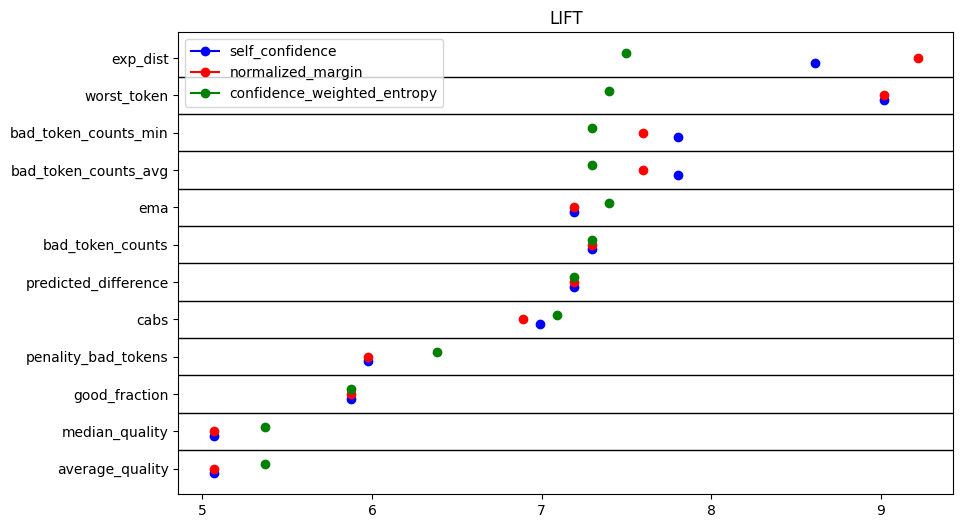

In [94]:
plot('lift')

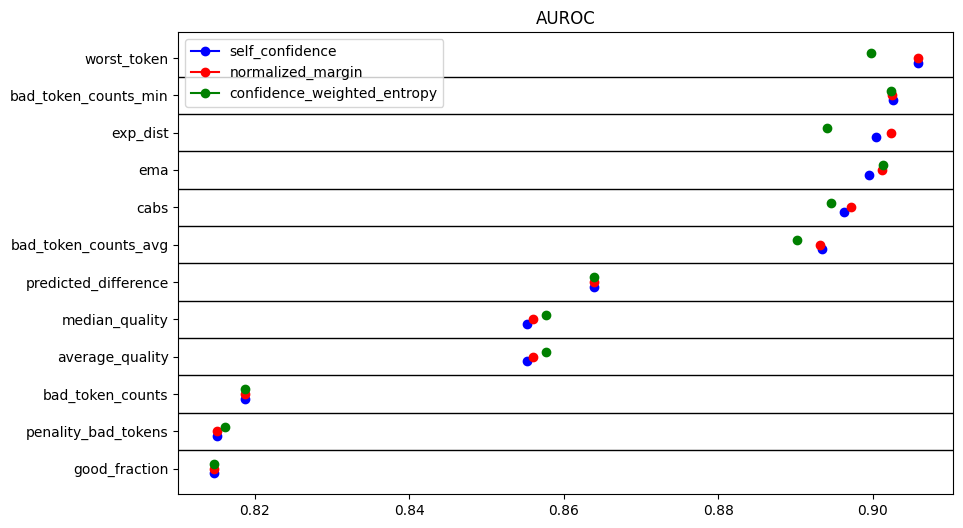

In [95]:
plot('auroc')

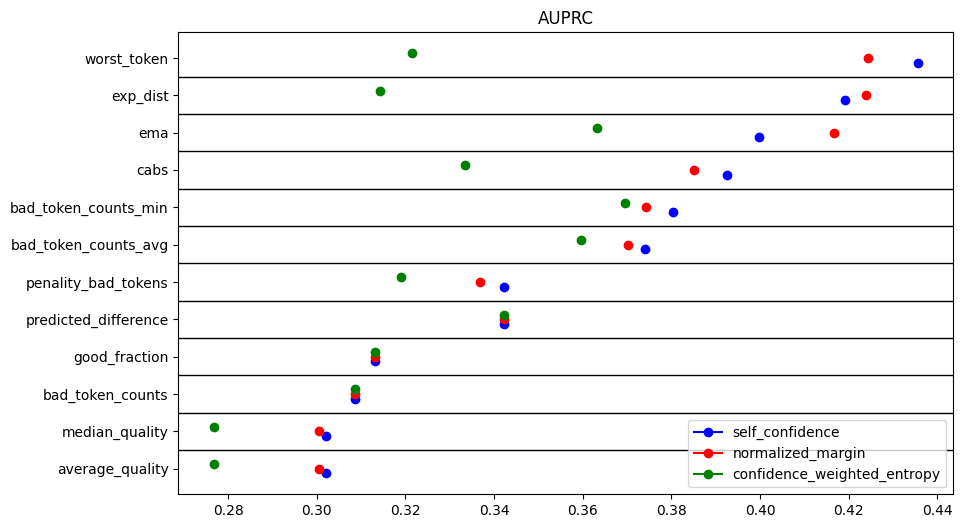

In [96]:
plot('auprc')

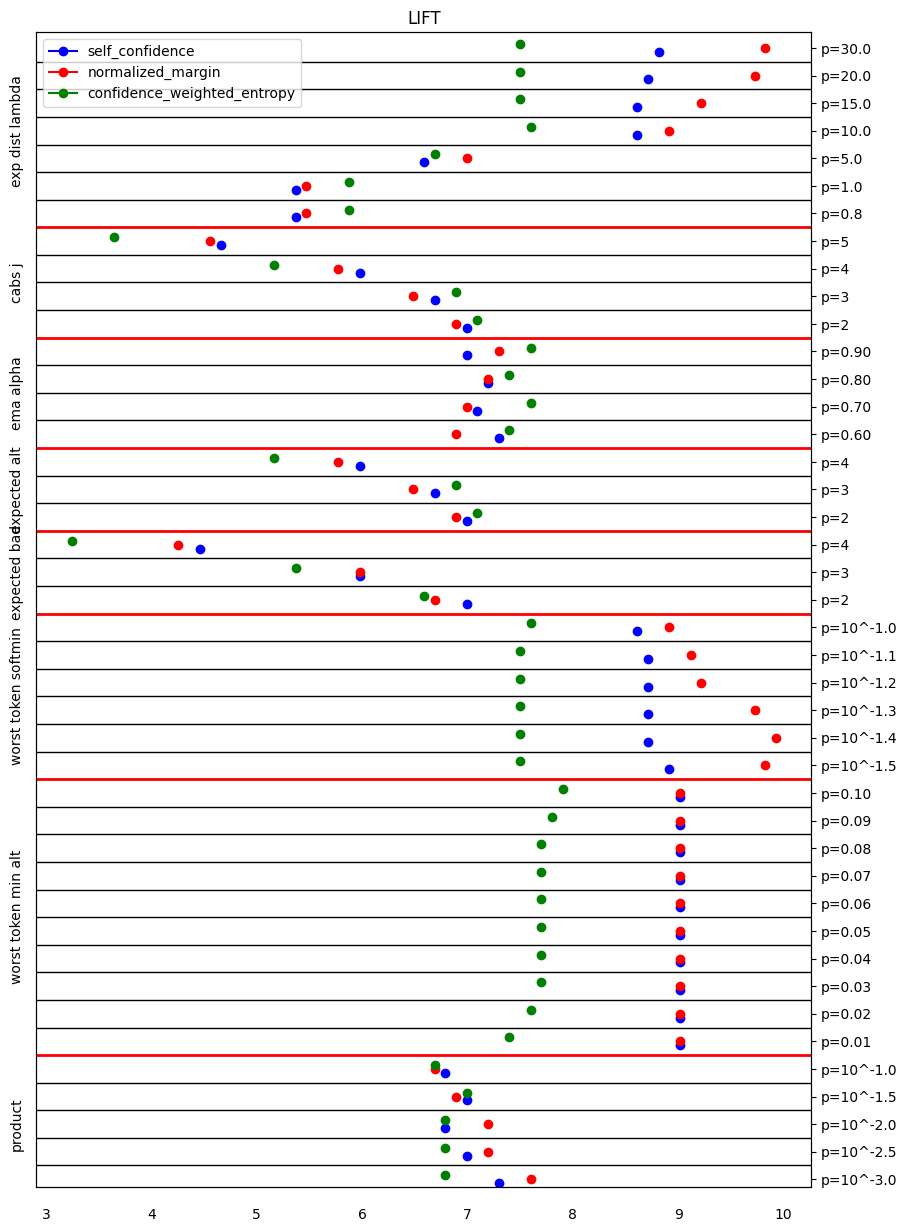

In [97]:
plot_hyper('lift')

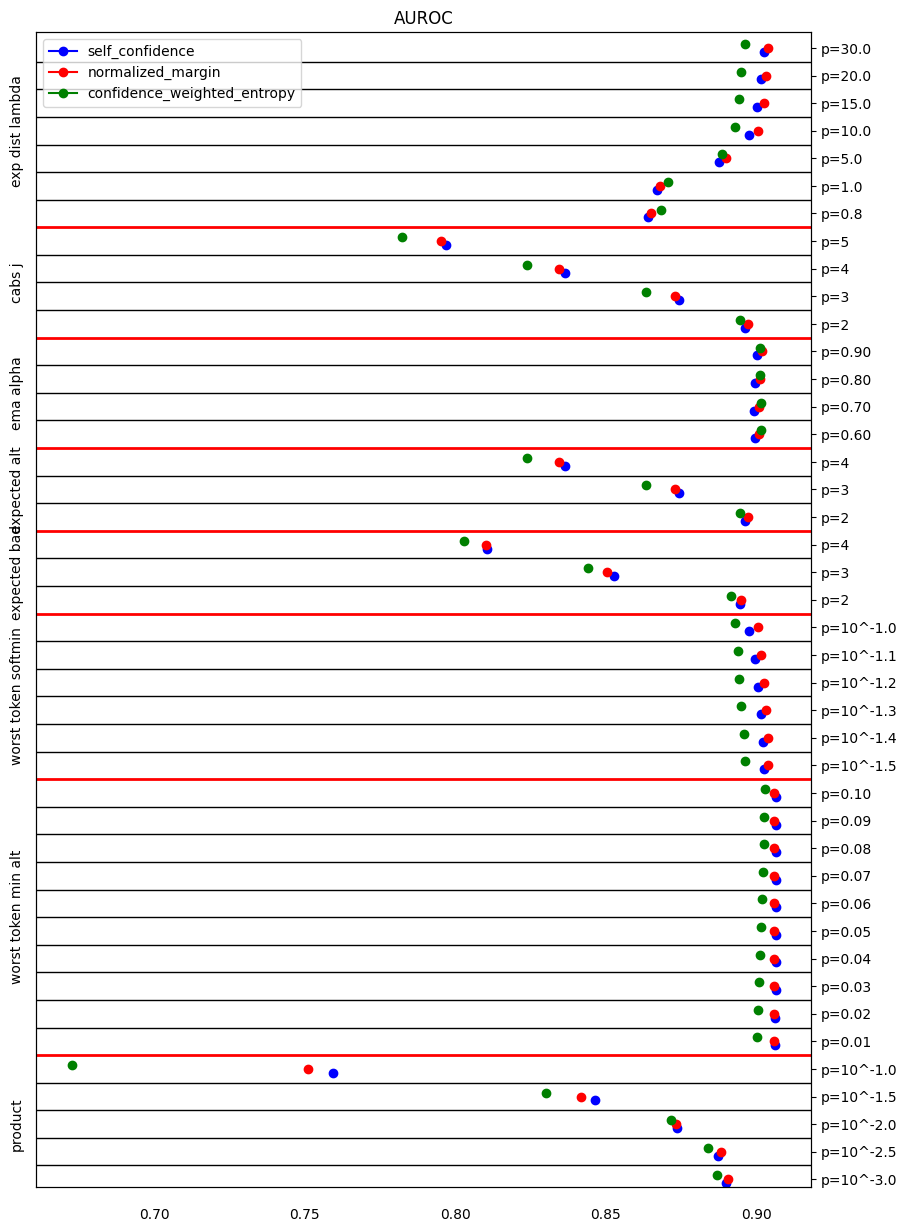

In [98]:
plot_hyper('auroc')

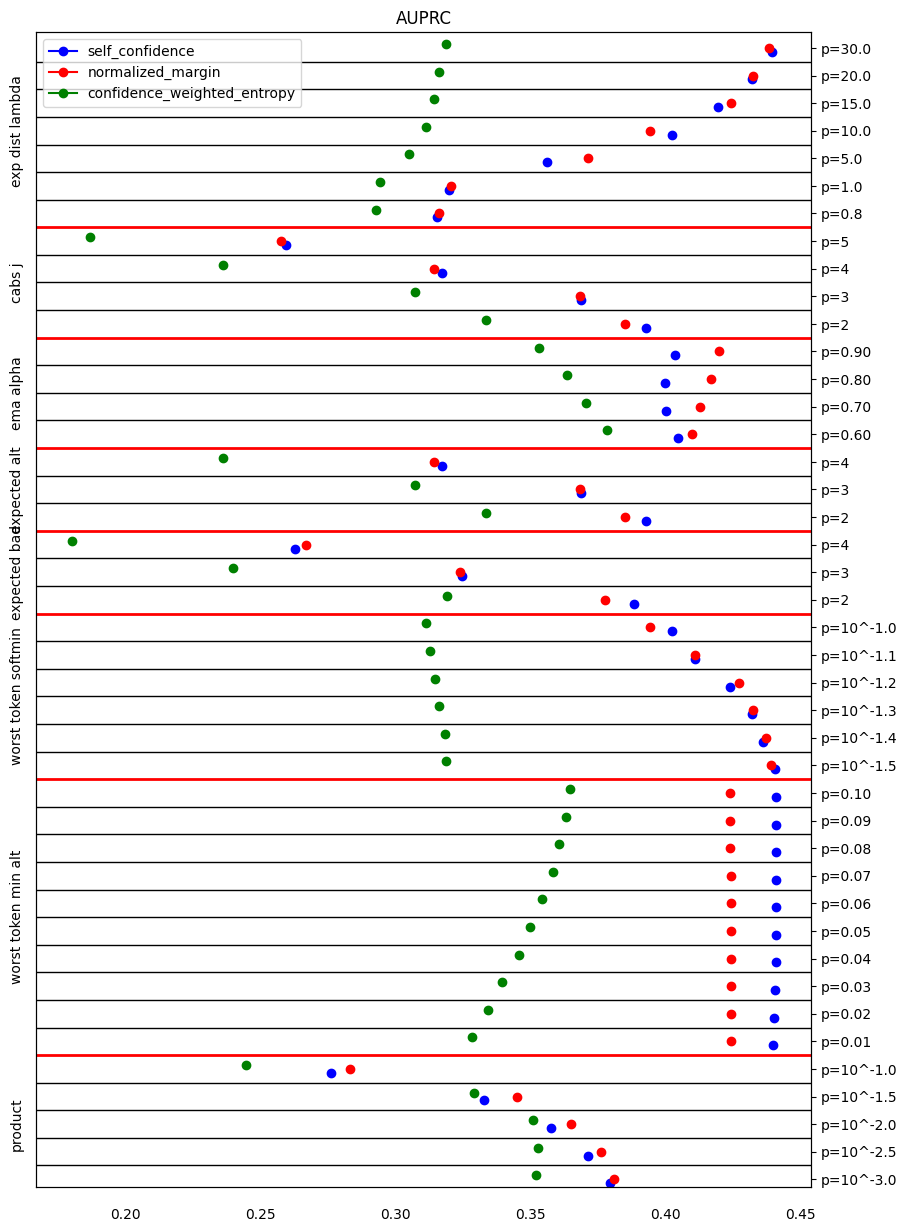

In [99]:
plot_hyper('auprc')

### Experiment B: xlm

In [100]:
model_name = 'xlm-roberta-large-finetuned-conll03-english'
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline(task="ner", model=model, tokenizer=tokenizer)

sentence_tokens = [[tokenizer.decode(token) for token in tokenizer(sentence)['input_ids']] for sentence in sentences]
sentence_tokens = [[token.replace('#', '') for token in sentence_token][1:-1] for sentence_token in sentence_tokens]

sentence_probs = []
for i in tqdm(range(len(sentences))):
    processed = next(pipe.preprocess(sentences[i]))
    forward_result = pipe.forward(processed)
    logits = forward_result["logits"][0].numpy()
    probs = np.array([np.exp(logit) / np.sum(np.exp(logit)) for logit in logits])
    probs = probs[1:-1]
    sentence_probs.append(probs)


model_maps = [4, 1, 3, 4, 1, 3, 2, 0]
sentence_probs = list(map(merge_probs, sentence_probs, repeat(model_maps)))
pred_probs = list(map(get_pred_probs, sentence_probs, sentence_tokens, given_words))

statistics = {(method, cleanlab_method): evaluate(method, cleanlab_method, pred_probs, error)
              for method in methods_without_hyper for cleanlab_method in cleanlab_methods}

statistics_hyper = {(method, cleanlab_method, param): evaluate(method, cleanlab_method, pred_probs, error, param=param)
                    for method in methods_with_hyper
                    for param in hyperparameters[method]
                    for cleanlab_method in cleanlab_methods}

config.json:   0%|          | 0.00/852 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

100%|██████████| 3449/3449 [17:37<00:00,  3.26it/s]


In [101]:
os.makedirs('experiments', exist_ok=True)
with open('experiments/experiment_b.json', 'w') as file:
    json.dump({str(key): value for key, value in statistics.items()}, file)

with open('experiments/experiment_b_hyper.json', 'w') as file:
    json.dump({str(key): value for key, value in statistics_hyper.items()}, file)

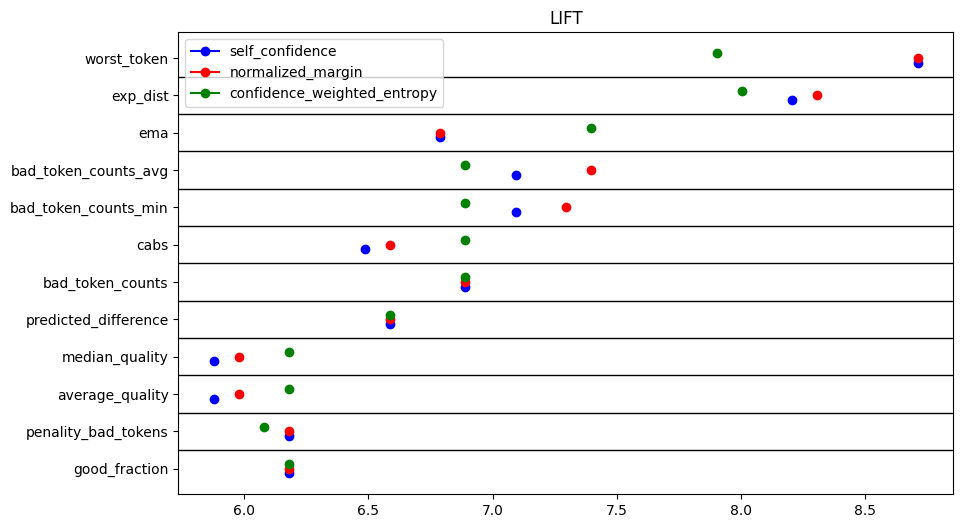

In [102]:
plot('lift')

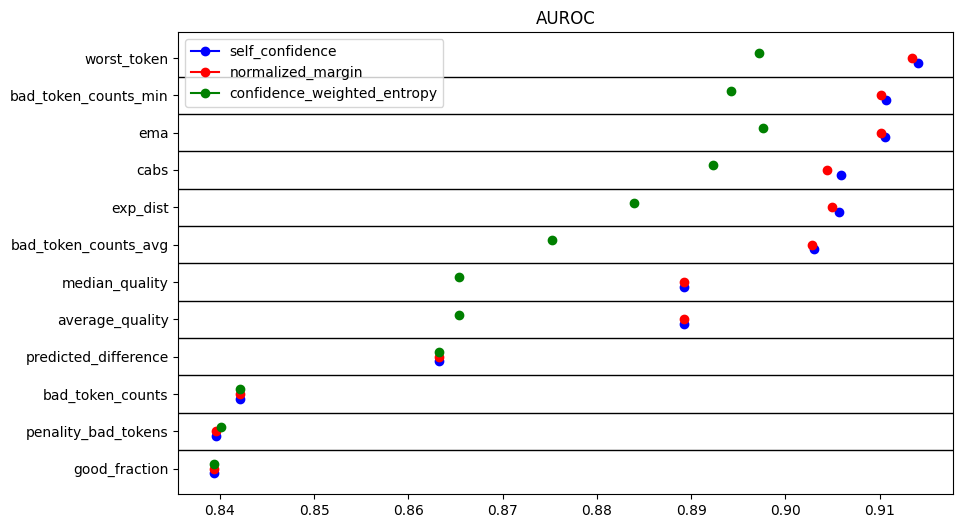

In [103]:
plot('auroc')

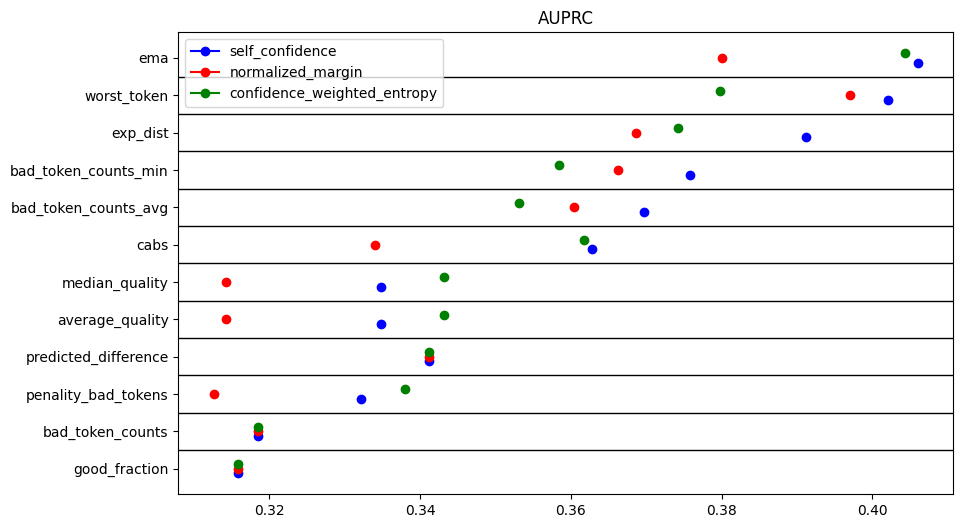

In [104]:
plot('auprc')

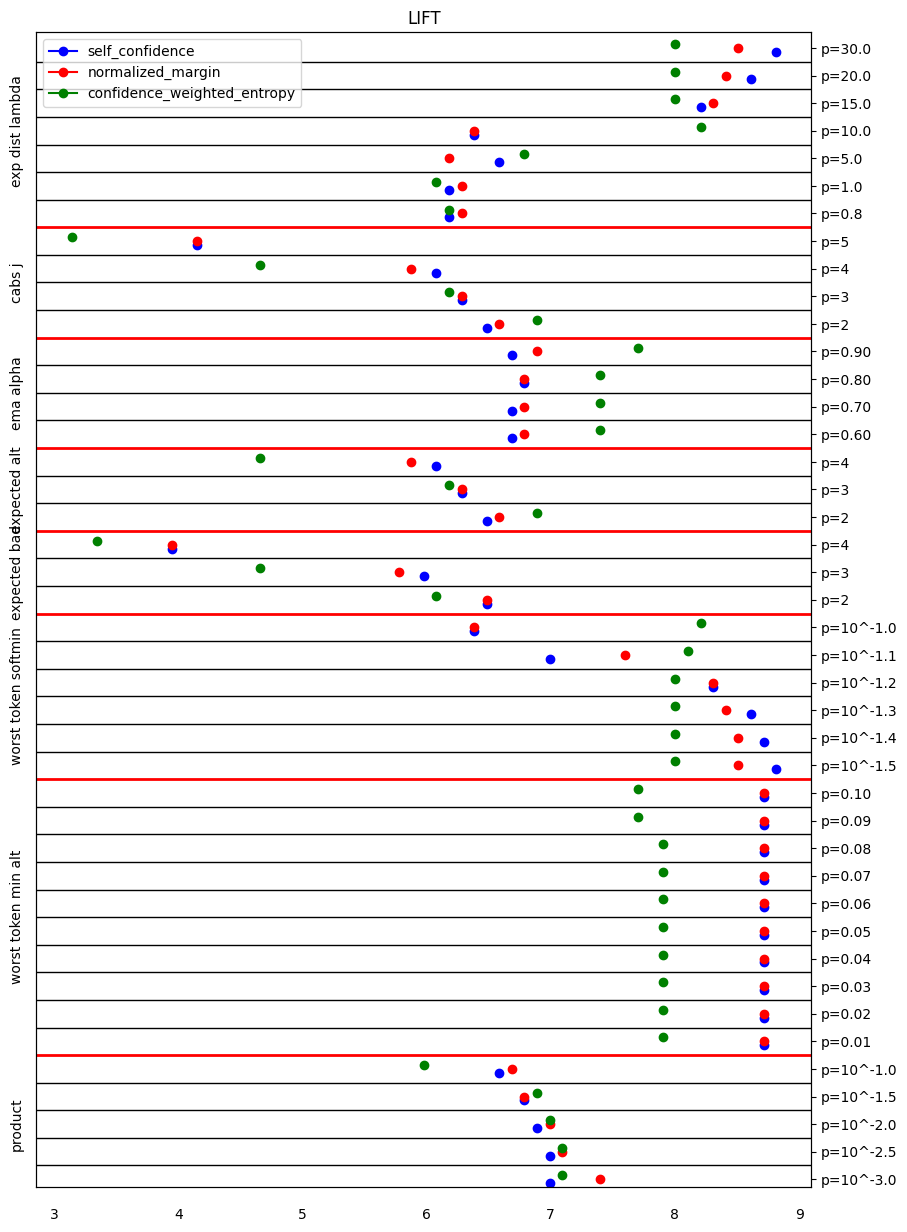

In [105]:
plot_hyper('lift')

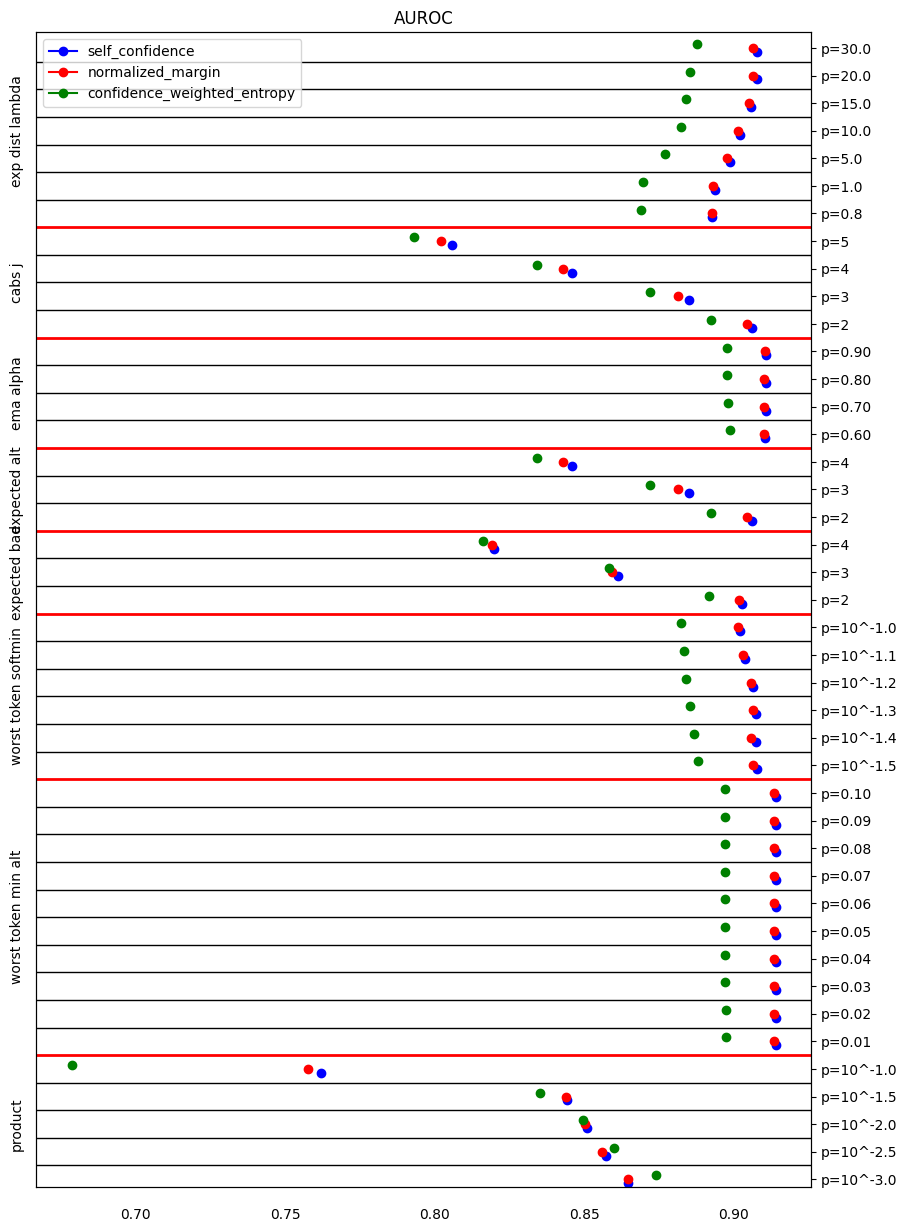

In [106]:
plot_hyper('auroc')

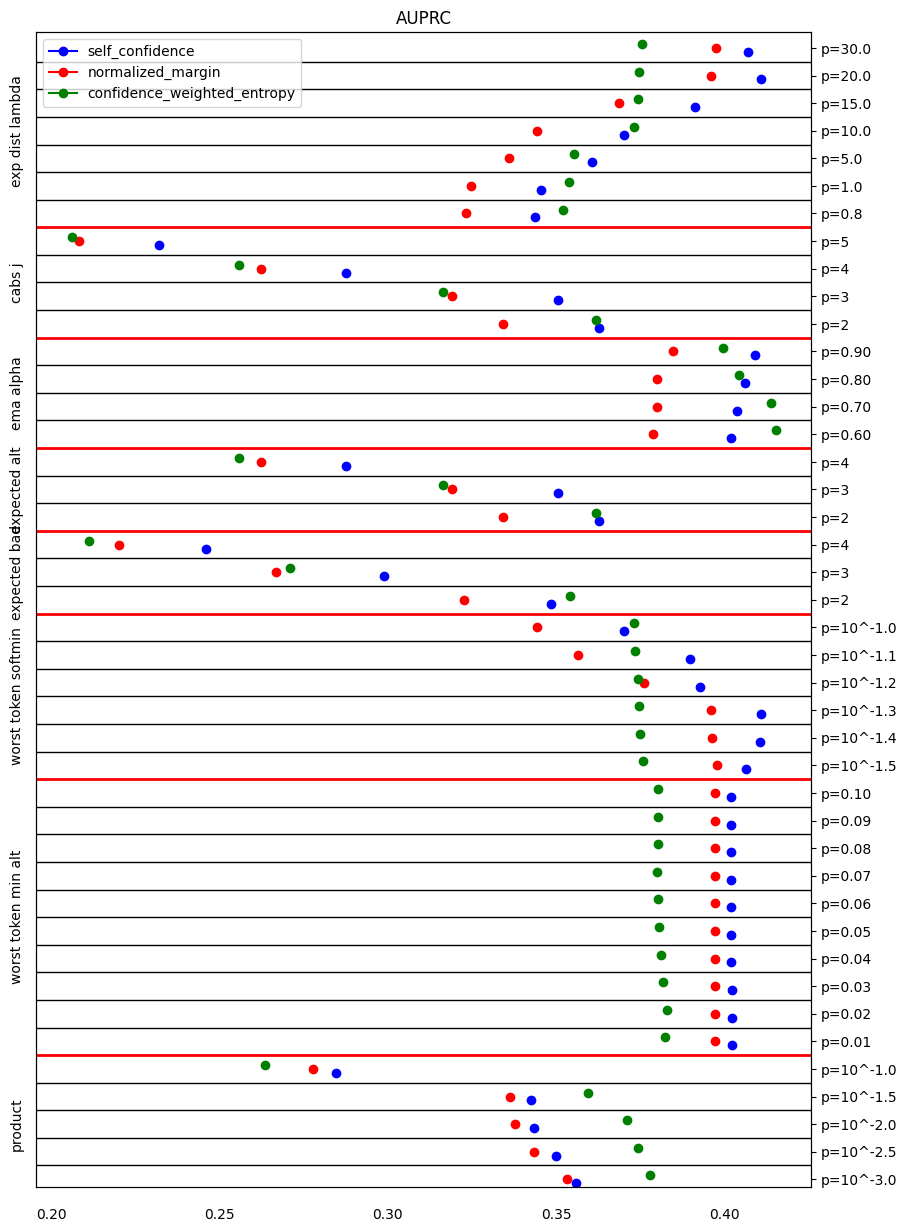

In [107]:
plot_hyper('auprc')

### Experiment C: bert (unmerged)

In [108]:
model_name = 'dslim/bert-base-NER'
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
pipe = pipeline(task="ner", model=model, tokenizer=tokenizer)

sentence_tokens = [[tokenizer.decode(token) for token in tokenizer(sentence)['input_ids']] for sentence in sentences]
sentence_tokens = [[token.replace('#', '') for token in sentence_token][1:-1] for sentence_token in sentence_tokens]

sentence_probs = []
for i in tqdm(range(len(sentences))):
    processed = next(pipe.preprocess(sentences[i]))
    forward_result = pipe.forward(processed)
    logits = forward_result["logits"][0].numpy()
    probs = np.array([np.exp(logit) / np.sum(np.exp(logit)) for logit in logits])
    probs = probs[1:-1]
    sentence_probs.append(probs)

pred_probs = list(map(get_pred_probs, sentence_probs, sentence_tokens, given_words))

statistics = {(method, cleanlab_method): evaluate(method, cleanlab_method, pred_probs, error_unmerged, unmerged=True)
              for method in methods_without_hyper for cleanlab_method in cleanlab_methods}

statistics_hyper = {(method, cleanlab_method, param): evaluate(method, cleanlab_method, pred_probs, error_unmerged, unmerged=True, param=param)
                    for method in methods_with_hyper
                    for param in hyperparameters[method]
                    for cleanlab_method in cleanlab_methods}

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3449/3449 [05:08<00:00, 11.17it/s]


In [116]:
os.makedirs('experiments', exist_ok=True)
with open('experiments/experiment_c.json', 'w') as file:
    json.dump({str(key): value for key, value in statistics.items()}, file)

with open('experiments/experiment_c_hyper.json', 'w') as file:
    json.dump({str(key): value for key, value in statistics_hyper.items()}, file)

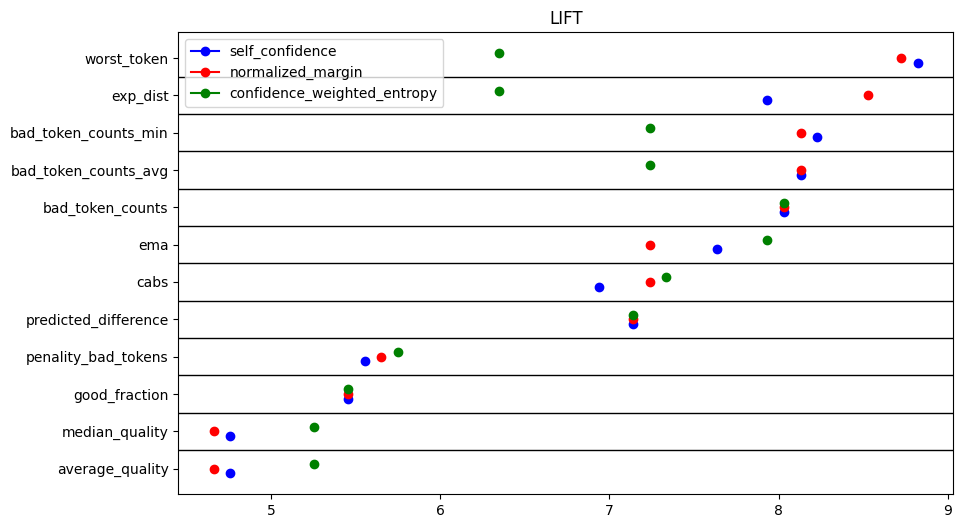

In [110]:
plot('lift')

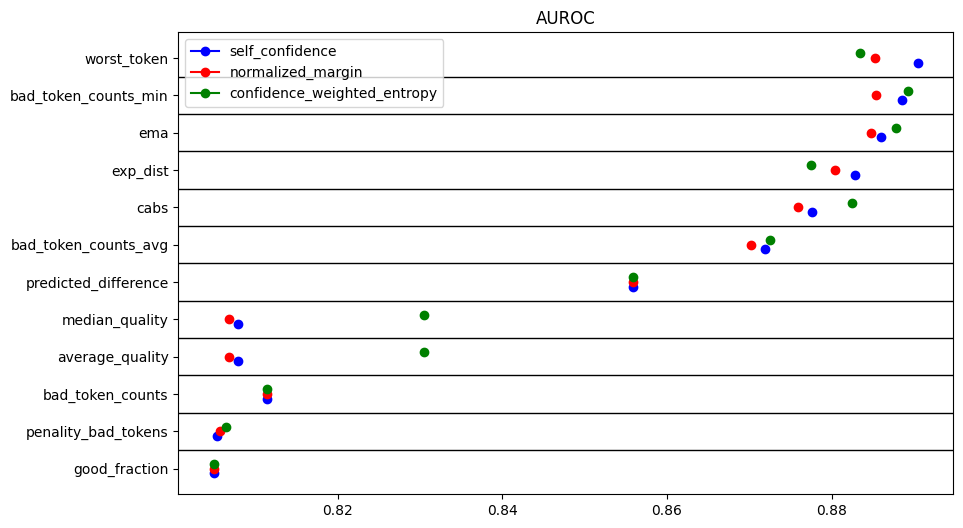

In [111]:
plot('auroc')

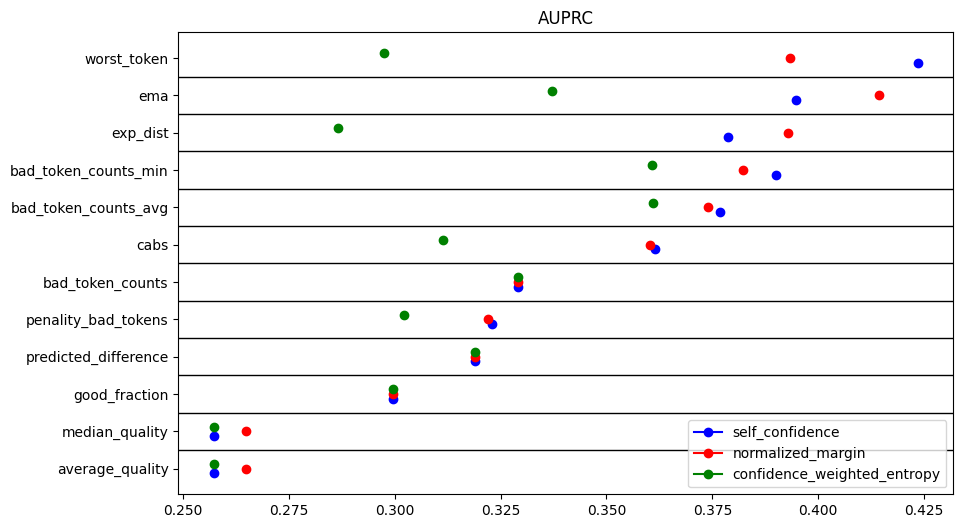

In [112]:
plot('auprc')

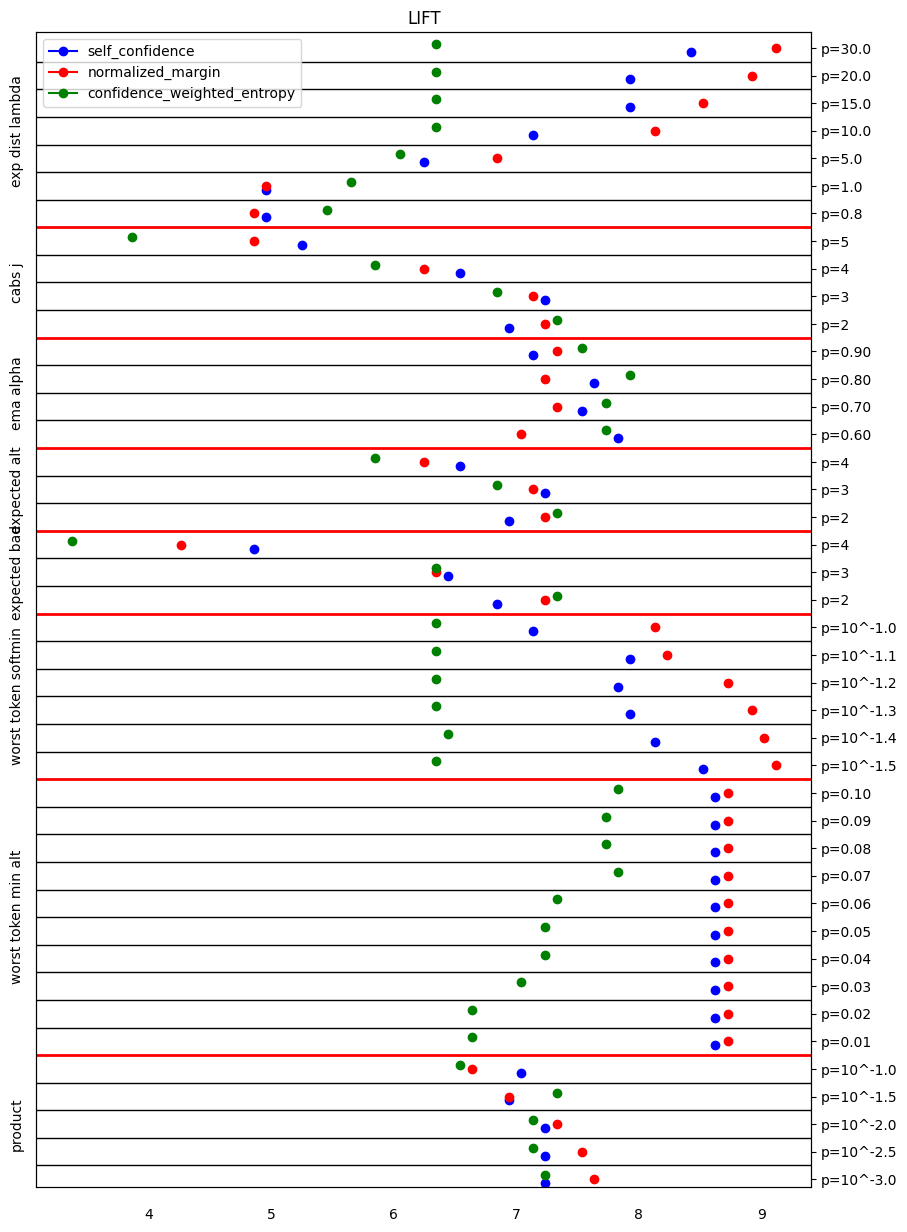

In [113]:
plot_hyper('lift')

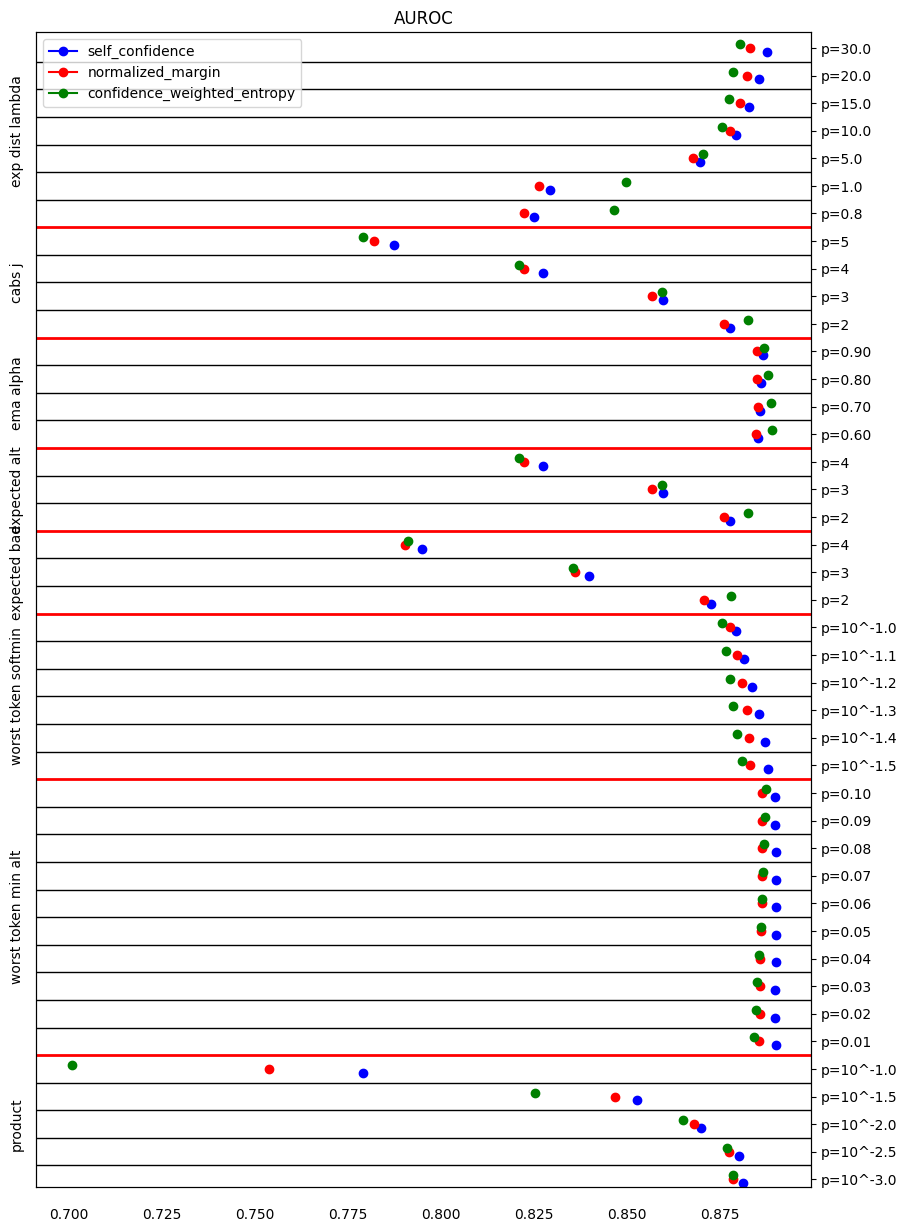

In [114]:
plot_hyper('auroc')

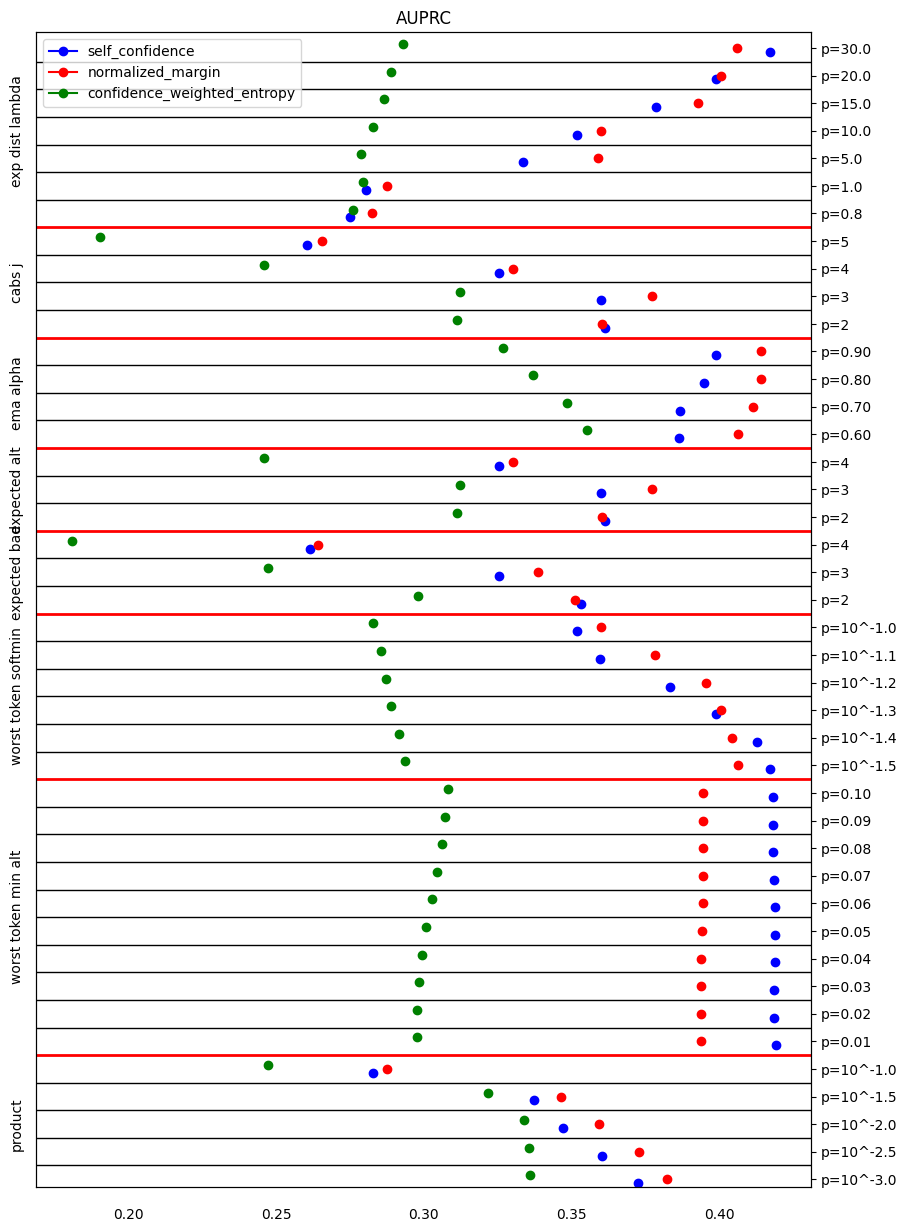

In [115]:
plot_hyper('auprc')

## Generate sythetic noise to the train set with specific `noise_rate`, `sparsity` and `diversity` **(optional)**

In [56]:
def generate_n_limited_probs_sum_to_m(n, m, min_prob=0.0, max_prob=1.0):

    probs = np.random.dirichlet(np.ones(n)) * m

    min_value = min(probs)
    max_value = max(probs)
    while max_value > max_prob:
        new_min = min_value + (max_value - max_prob)
        adjustment = (max_prob - new_min) * np.random.rand()
        probs[np.argmin(probs)] = new_min + adjustment
        probs[np.argmax(probs)] = max_prob - adjustment
        min_value = min(probs)
        max_value = max(probs)

    min_value = min(probs)
    max_value = max(probs)
    while min_value < (min_prob):
        new_max = max_value - (min_prob - min_value)
        adjustment = (new_max - min_prob) * np.random.rand()
        probs[np.argmax(probs)] = new_max - adjustment
        probs[np.argmin(probs)] = min_prob + adjustment
        min_value = min(probs)
        max_value = max(probs)

    return probs

def generate_noise_matrix(num_classes, noise_rate, sparsity, diversity):
    trace = num_classes - (noise_rate * num_classes)
    noise_matrix = np.zeros(shape=(num_classes, num_classes))
    diagonals = generate_n_limited_probs_sum_to_m(num_classes,
                                          trace,
                                          min_prob=(1.0 - diversity) * (trace / num_classes),
                                          max_prob=np.clip((1.0 + diversity) * (trace / num_classes), None, 1.0))
    np.fill_diagonal(noise_matrix, diagonals)

    off_diagonals_mask = ~np.eye(num_classes, dtype=bool)
    off_diagonals_indices = np.argwhere(off_diagonals_mask)
    np.random.shuffle(off_diagonals_indices)

    num_off_diagonal_non_zeros = int((num_classes * (num_classes - 1)) * (1 - sparsity))
    off_diagonals_indices = off_diagonals_indices[: num_off_diagonal_non_zeros]

    for i in range(noise_matrix.shape[1]):
        m = 1.0 - noise_matrix[i, i]
        filtered_off_diagonals_indices = off_diagonals_indices[off_diagonals_indices[:, 1] == i]
        if len(filtered_off_diagonals_indices) != 0:
            vector = generate_n_limited_probs_sum_to_m(len(filtered_off_diagonals_indices), m)
            for i, idx in enumerate(filtered_off_diagonals_indices):
                noise_matrix[idx[0], idx[1]] = vector[i]
        else:
            continue

    return noise_matrix

In [79]:
def inject_noise(ground_truth_labels, noise_rate=0.1, sparsity=0.1, diversity=0.2):
    num_sample_sentences = int(round(noise_rate * len(ground_truth_labels)))
    sample_sentences_indexes = random.sample(range(len(ground_truth_labels)), num_sample_sentences)
    sample_sentences = [ground_truth_labels.copy()[index] for index in sample_sentences_indexes]
    sublist_lengths = [len(sublist) for sublist in sample_sentences]
    flat_sample_gt = np.array([element for sublist in sample_sentences.copy() for element in sublist])

    noisy_labels = list()

    num_classes = np.unique(flat_sample_gt).shape[0]
    noise_matrix = generate_noise_matrix(num_classes, noise_rate, sparsity, 0.2)
    print(f"Generated Noise Matrix with noise_rate={noise_rate}, sparsity={sparsity} and diversity={diversity}:")
    print(np.round(noise_matrix, 3))
    print('-' * 80, '\n')

    counter = Counter(flat_sample_gt)
    flat_noisy_labels = flat_sample_gt.copy()

    for i in range(num_classes):
        for j in range(num_classes):
            if i == j:
                continue
            num_samples = int(round(noise_matrix[j, i] * counter[i]))
            indices_to_change = np.random.choice(np.where(flat_sample_gt == i)[0], num_samples, replace=False)
            flat_noisy_labels[indices_to_change] = j

    first_index = 0
    reshaped_noisy_labels = list()
    for l in sublist_lengths:
        reshaped_noisy_labels.append(list(flat_noisy_labels[first_index: first_index + l]))
        first_index += l

    noisy_labels = ground_truth_labels.copy()
    for i in range(len(sample_sentences)):
        noisy_labels[sample_sentences_indexes[i]] = reshaped_noisy_labels[i]

    return noisy_labels

In [80]:
noisy_labels = inject_noise(ground_truth_labels)
noisy_labels_unmerged = inject_noise(ground_truth_labels_unmerged)

Generated Noise Matrix with noise_rate=0.1, sparsity=0.1 and diversity=0.2:
[[0.984 0.011 0.    0.015 0.04 ]
 [0.005 0.849 0.002 0.002 0.077]
 [0.001 0.    0.972 0.035 0.087]
 [0.    0.036 0.016 0.922 0.023]
 [0.01  0.104 0.01  0.027 0.773]]
-------------------------------------------------------------------------------- 

Generated Noise Matrix with noise_rate=0.1, sparsity=0.1 and diversity=0.2:
[[0.899 0.002 0.006 0.001 0.    0.001 0.001 0.012 0.034]
 [0.005 0.979 0.    0.02  0.    0.    0.002 0.044 0.092]
 [0.053 0.007 0.888 0.002 0.002 0.002 0.002 0.012 0.012]
 [0.005 0.003 0.044 0.872 0.001 0.001 0.    0.061 0.019]
 [0.004 0.003 0.021 0.06  0.846 0.002 0.002 0.    0.008]
 [0.022 0.002 0.018 0.021 0.048 0.994 0.    0.018 0.   ]
 [0.001 0.003 0.001 0.008 0.062 0.    0.985 0.    0.006]
 [0.002 0.001 0.008 0.001 0.04  0.    0.006 0.833 0.025]
 [0.009 0.001 0.015 0.015 0.    0.    0.002 0.02  0.804]]
-------------------------------------------------------------------------------- 

